## Real or Not? NLP with Disaster Tweets

Kaggle : NLP Getting Started Task - https://www.kaggle.com/c/nlp-getting-started/

### Index
1. Get Libraries
2. Data Load 
3. Data Visualization
4. Word Cloud
5. Text Preprocessing
6. Build the Model
7. Model Evaluation
8. Predictions

### 1. Get Libraries

In [ ]:
import pandas as pd # data processing
import numpy as np # linear algebra

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import os
import re
import time 
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

import nltk  
nltk.download('stopwords') 
from nltk.corpus import stopwords 

### 2. Data Load

In [2]:
train = pd.read_csv("nlp/train.csv")
test = pd.read_csv("nlp/test.csv")
submission =  pd.read_csv("nlp/sample_submission.csv")

In [3]:
    train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


### 3. Data Visualizations

<BarContainer object of 5 artists>

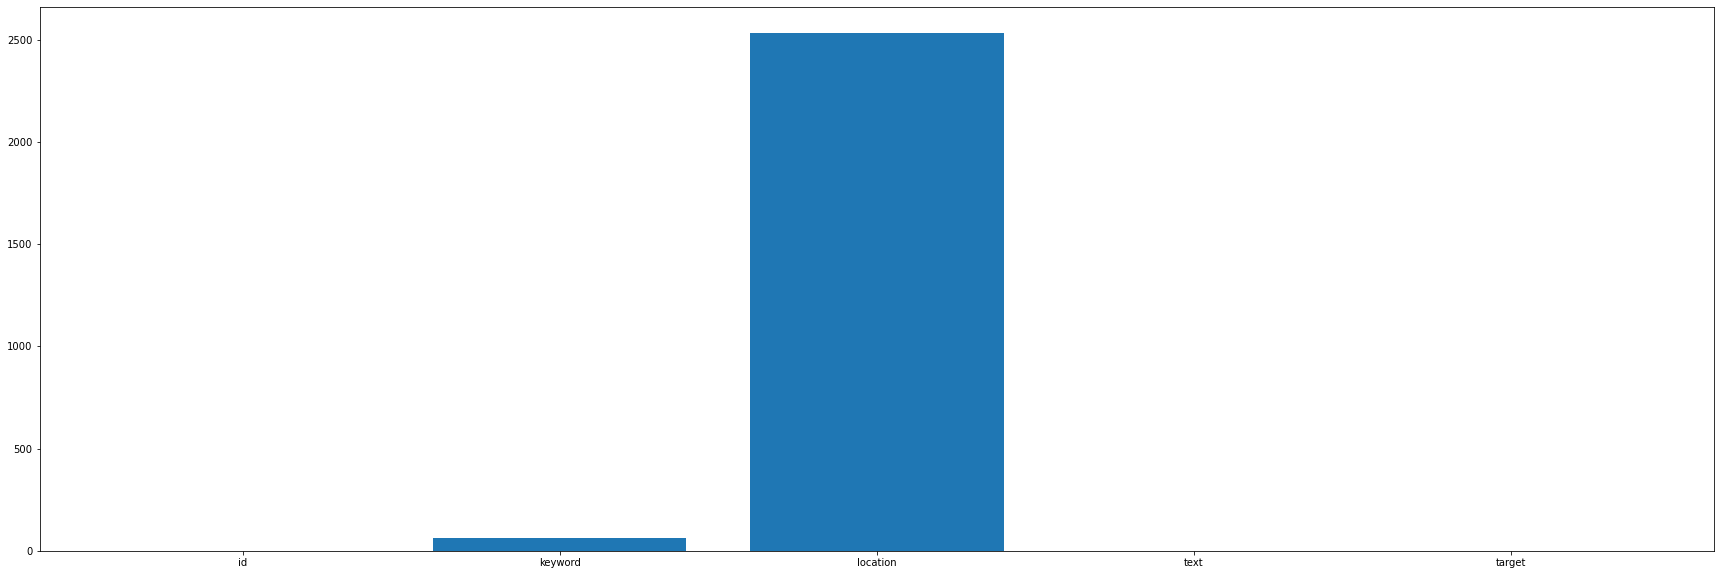

In [5]:
nan_columns = []
nan_values = []

for column in train.columns:
    nan_columns.append(column)
    nan_values.append(train[column].isnull().sum())

fig, ax = plt.subplots(figsize=(30,10))
plt.bar(nan_columns, nan_values)

<BarContainer object of 4 artists>

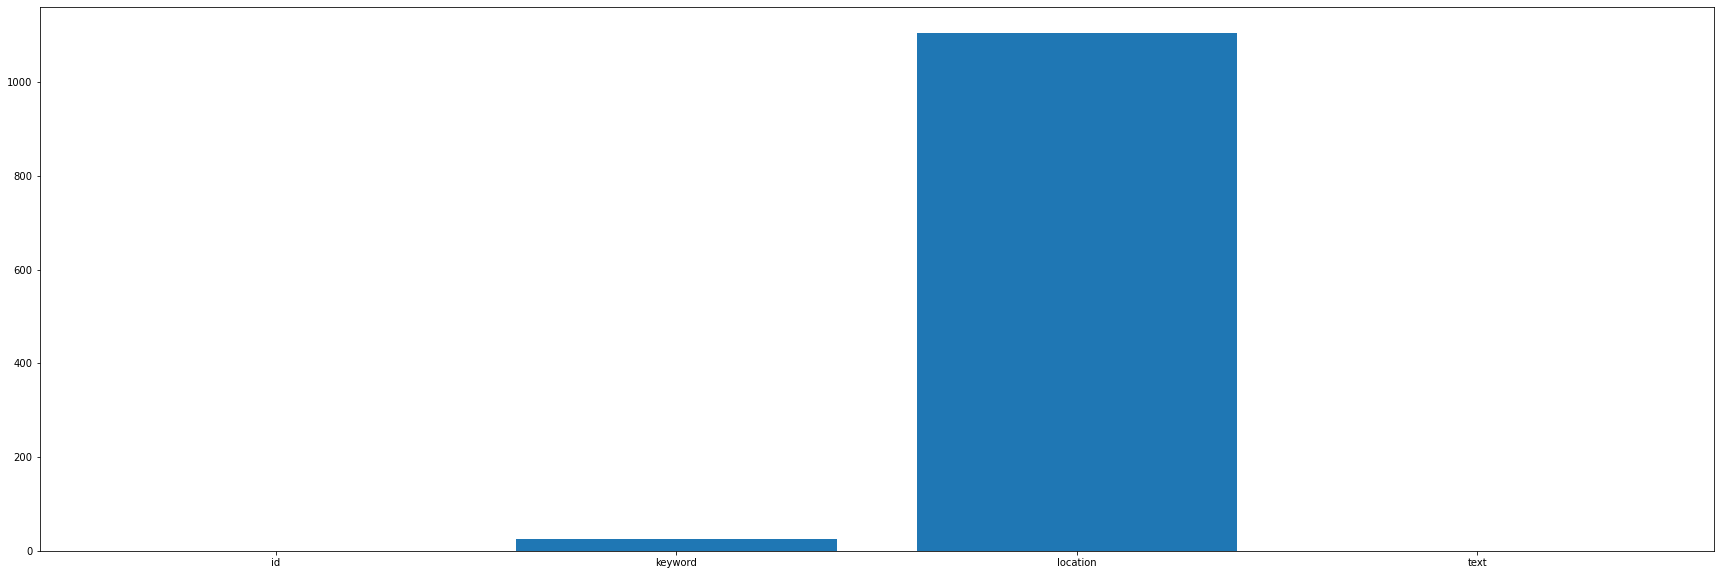

In [6]:
nan_columns = []
nan_values = []

for column in test.columns:
    nan_columns.append(column)
    nan_values.append(test[column].isnull().sum())

fig, ax = plt.subplots(figsize=(30,10))
plt.bar(nan_columns, nan_values)

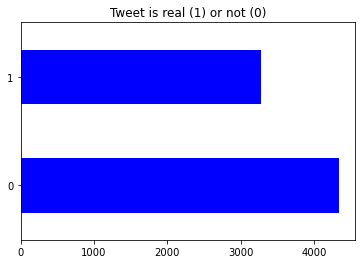

In [7]:
train.target.value_counts().plot(kind='barh', title='Tweet is real (1) or not (0)',color='b')

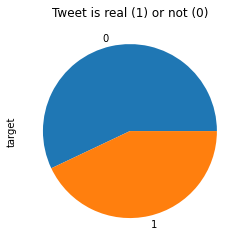

In [8]:
train.target.value_counts().plot(kind='pie', title='Tweet is real (1) or not (0)')

In train dataset, we have 43% of real data and 57% of fake data

In [9]:
train.keyword.nunique()  # 221 unique keywords

221

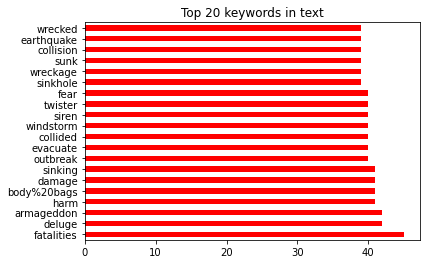

In [10]:
train.keyword.value_counts()[:20].plot(kind='barh', title='Top 20 keywords in text', color='r')

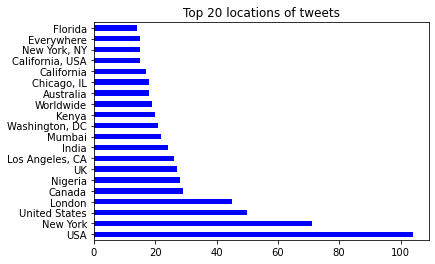

In [11]:
train.location.value_counts()[:20].plot(kind='barh', title='Top 20 locations of tweets', color='b')

### 4. Word Count

In [12]:
STOPWORDS.add('https')  # remove https from the world Cloud

def word_count(text):    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    for val in text: 
        # typecaste each val to string 
        val = str(val) 
        # split the value 
        tokens = val.split() 
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '
    wordcloud = WordCloud(width = 5000, height = 4000, background_color ='black', stopwords = stopwords,
                          min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.show() 

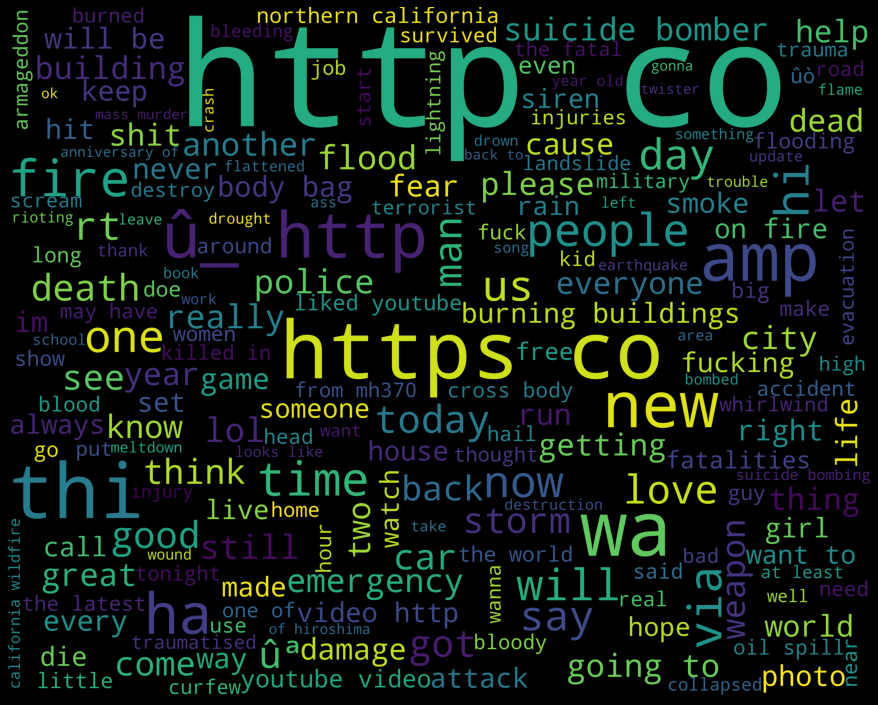

In [13]:
text = train.text.values
word_count(text)

### 5. Text Preprocessing

In [14]:
train.loc[train['text'].str.contains('http')].target.value_counts()

1    2172
0    1799
Name: target, dtype: int64

In [15]:
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def remove_html(text):
    no_html= pattern.sub('',text)
    return no_html

# Remove all text that start with html
train['text']=train['text'].apply(lambda x : remove_html(x))

In [16]:
# lets check if this clean works
train.loc[train['text'].str.contains('http')].target.value_counts()

0    1
Name: target, dtype: int64

In [17]:
# Remove all text that start with html in test
test['text']=test['text'].apply(lambda x : remove_html(x))

In [18]:
# Now remove stopwords, pass to lower add delimiter and more
def clean_text(text): 
    text = re.sub('[^a-zA-Z]', ' ', text)  
    text = text.lower()  
    # split to array(default delimiter is " ") 
    text = text.split()  
    text = [w for w in text if not w in set(stopwords.words('english'))] 
    text = ' '.join(text)    
    return text

In [19]:
text = train.text[3]
print(text)
clean_text(text)

13,000 people receive #wildfires evacuation orders in California 


'people receive wildfires evacuation orders california'

In [20]:
# Apply clean text 
train['text'] = train['text'].apply(lambda x : clean_text(x))
test['text']=test['text'].apply(lambda x : clean_text(x))

In [21]:
# How many unique words we have in train text
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [22]:
text_values = train["text"]
counter = counter_word(text_values)

In [23]:
print(f"The len of unique words is: {len(counter)}")
list(counter.items())[:10]

The len of unique words is: 16070


[('deeds', 2),
 ('reason', 20),
 ('earthquake', 50),
 ('may', 89),
 ('allah', 9),
 ('forgive', 2),
 ('us', 128),
 ('forest', 66),
 ('fire', 254),
 ('near', 56)]

## Train Test Split

In [24]:
# The maximum number of words to be used. (most frequent)
vocab_size = len(counter)
embedding_dim = 32

# Max number of words in each complaint.
max_length = 20
trunc_type='post'
padding_type='post'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = 6090
seq_len = 12

In [25]:
# this is base in 80% of the data, an only text and targert at this moment

training_sentences = train.text[0:training_size]
training_labels = train.target[0:training_size]

testing_sentences = train.text[training_size:]
testing_labels = train.target[training_size:]

In [26]:
print('The Shape of training ',training_sentences.shape)
print('The Shape of testing',testing_sentences.shape)

The Shape of training  (6090,)
The Shape of testing (1523,)


In [27]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [28]:
word_index = tokenizer.word_index

In [29]:
# Lets see the first 10 elements
print("THe first word Index are: ")
for x in list(word_index)[0:10]:
    print (" {},  {} ".format(x,  word_index[x]))
    
# If you want to see completed -> word_index    

THe first word Index are: 
 <XXX>,  1 
 amp,  2 
 like,  3 
 fire,  4 
 get,  5 
 via,  6 
 new,  7 
 people,  8 
 news,  9 
 emergency,  10 


In [30]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [31]:
print(train.text[1])
print(training_sequences[1])

forest fire near la ronge sask canada
[74, 4, 120, 571, 5480, 5481, 1184]


# Check reverse to understand how it works

In [32]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [33]:
# Lets see the first 10 elements
print("THe first reverse word Index are: ")
for x in list(reverse_word_index)[0:10]:
    print (" {},  {} ".format(x,  reverse_word_index[x]))

# If you want to see completed -> reverse_word_index

THe first reverse word Index are: 
 1,  <XXX> 
 2,  amp 
 3,  like 
 4,  fire 
 5,  get 
 6,  via 
 7,  new 
 8,  people 
 9,  news 
 10,  emergency 


In [34]:
def decode(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode(training_sequences[1]) # this can be usefull to check predictions

'forest fire near la ronge sask canada'

In [35]:
training_padded[1628]

array([7779, 1150, 2107,  629, 2106, 1257,   52,  326, 2106, 1257,   52,
        326, 7780,    0,    0,    0,    0,    0,    0,    0])

In [36]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### 6. Build the Model

In [37]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # for binary clasification
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            514240    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 14)                1806      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 565,725
Trainable params: 565,725
Non-trainable params: 0
_________________________________________________________________


In [38]:
start_time = time.time()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

final_time = (time.time()- start_time)/60
print(f'The time in minutos: {final_time}')

Epoch 1/10
191/191 [==============================] - 4s 21ms/step - loss: 0.5762 - accuracy: 0.6865 - val_loss: 0.4841 - val_accuracy: 0.7728
Epoch 2/10
191/191 [==============================] - 3s 16ms/step - loss: 0.3121 - accuracy: 0.8816 - val_loss: 0.5095 - val_accuracy: 0.7584
Epoch 3/10
191/191 [==============================] - 3s 16ms/step - loss: 0.1763 - accuracy: 0.9424 - val_loss: 0.6713 - val_accuracy: 0.7295
Epoch 4/10
191/191 [==============================] - 3s 16ms/step - loss: 0.1275 - accuracy: 0.9603 - val_loss: 0.5190 - val_accuracy: 0.7446
Epoch 5/10
191/191 [==============================] - 3s 16ms/step - loss: 0.1046 - accuracy: 0.9673 - val_loss: 0.6491 - val_accuracy: 0.7347
Epoch 6/10
191/191 [==============================] - 3s 17ms/step - loss: 0.0871 - accuracy: 0.9745 - val_loss: 0.7370 - val_accuracy: 0.7466ura
Epoch 7/10
191/191 [==============================] - 3s 16ms/step - loss: 0.0674 - accuracy: 0.9778 - val_loss: 1.0084 - val_accuracy: 0.7

In [39]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.576194,0.686535,0.484057,0.772817
1,0.312067,0.881609,0.509508,0.758372
2,0.176331,0.942365,0.671295,0.729481
3,0.127538,0.960263,0.519000,0.744583
4,0.104578,0.967323,0.649064,0.734734


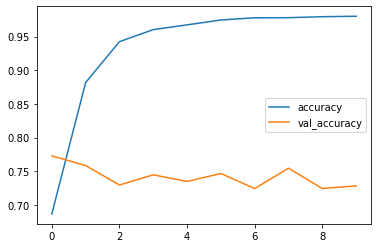

In [40]:
model_loss[['accuracy','val_accuracy']].plot();

### 7. Model Evaluation

In [41]:
predictions = model.predict_classes(testing_padded)   # predict_ clases because is classification problem with the split test

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [42]:
predictions

array([[0],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [43]:
from sklearn.metrics import classification_report,confusion_matrix

# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

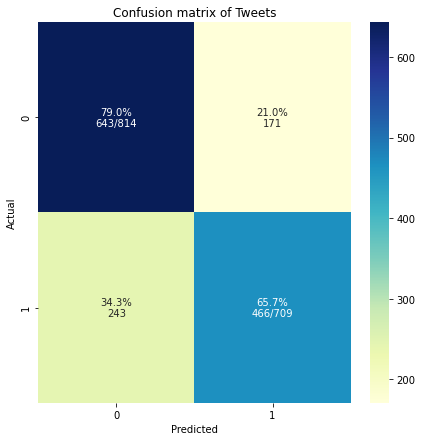

In [44]:
# Showing Confusion Matrix
plot_cm(testing_labels,predictions, 'Confusion matrix of Tweets', figsize=(7,7))

### 8. Predictions

In [45]:
test_sequences = tokenizer.texts_to_sequences(test.text)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [46]:
predictions = model.predict(test_padded)

In [47]:
# sample of submission
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [48]:
submission['target'] = (predictions > 0.5).astype(int)
submission

,id,target
0,0,0
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [49]:
submission.to_csv("submission.csv", index=False, header=True)